In [1]:
#Libraries for numeric computation and visualization
import numpy as np
import numpy.ma as ma
import pandas as pd
import random

import matplotlib.pyplot as plt


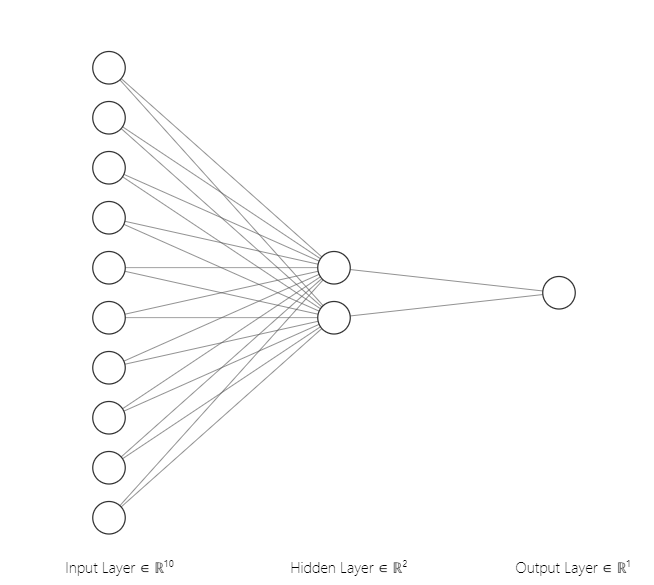

In [2]:
# Sigmoid non linearity function is used by the hidden layer and output neuron

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# derivative of sigmoid w.r.t z1

def sigmoid_derivative(z):
  return z*(1 - z)

In [3]:
# initializing random weights and bias
def defParameter(n , hid, out):
  np.random.seed(42)
  W1 = np.random.rand(n,hid)
  W2 = np.random.rand(hid,out)
  b1 = np.zeros((1,hid))
  b2 = np.zeros((1,out))

  # Initialize velocities for momentum of weights and bias that will increase the convergence speed and local minima
  vW1 = np.zeros_like(W1)
  vb1 = np.zeros_like(b1)
  vW2 = np.zeros_like(W2)
  vb2 = np.zeros_like(b2)
  return W1, W2, b1, b2,vW1,vb1,vW2,vb2

In [4]:
# split data into
def splitData(X, y):
    np.random.seed(42)
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, 80)

    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]

    return X_train, y_train, X_test, y_test

In [5]:
# Update weights and bias using hyperparameters-- learning rate and momentum

def updateParameter(W1, W2, b1, b2,vW1,vb1,vW2,vb2,b,lr,momentum):
  vW1 = momentum * vW1 - lr *b["dW1"]
  vb1 = momentum * vb1 - lr * b["db1"]
  vW2 = momentum * vW2 - lr * b["dW2"]
  vb2 = momentum * vb2 - lr * b["db2"]
  W1 = W1 +  vW1
  W2 = W2 + vW2
  b1 = b1 + vb1
  b2 = b2 + vb2
  return W1, W2, b1, b2

In [6]:
# forwarding the information from inputs X(10x1), W1(10x2), W2(2x1), b1(2x1),b2(1x1)
def forwardPass(W1, W2, b1, b2, X):
  v = {}
  v["neth1"] = np.dot(X, W1) + b1 # linear function between input and weights
  v["H1"] = sigmoid(v["neth1"]) # Activation function is used to capture Non Linearity in inputs
  v["neto1"] = np.dot(v["H1"], W2) + b2
  v["O1"] = sigmoid(v["neto1"]) # To get the probability of input being palindrome or not
  return v

In [7]:

def backwardPass(W2, b2, X, Y, v):
  d = {}

  d["dd1"] = v["O1"] - Y
  d["dW2"] = np.dot(v["H1"].T, d["dd1"])
  d["db2"] = np.sum(d["dd1"])
  d["dd2"] = np.dot(d["dd1"], W2.T) * sigmoid_derivative(v["H1"])
  d["db1"] = np.sum(d["dd2"])
  d["dW1"] = np.dot(X.T, d["dd2"])
  return d

In [8]:
#Accuracy of predicting input as palindrom or not
def compute_metric(target, pred):
  acc = np.sum(target == pred)*100/len(target)
  return acc

In [9]:
# Uses the updated weights(W1,W2,b1,b2) to classify the input as palindrome(1) or non palindrome(2) based on 50% as threshold
def predict(W1, W2, b1, b2, input):
  neth1 = np.dot(input, W1) + b1
  H1 = sigmoid(neth1)
  neto1 = np.dot(H1, W2) + b2
  O1 = sigmoid(neto1)
  p = O1 > 0.5
  return p.astype(int)

In [10]:
# Training the model to find the optimal values of weights that reduce the loss using gradient descent optimization.

def model(n, hid, out, iter, X, Y, lr):
  param = {}
  W1, W2, b1, b2,vW1,vb1,vW2,vb2 = defParameter(n, hid, out) # initialize parameters
  X_train, Y_train = X,Y
  for i in range(iter): # run through number of iterations
       f = forwardPass(W1, W2, b1, b2, X_train) # forward over training input
       b = backwardPass(W2, b2, X_train, Y_train, f)
       W1, W2, b1, b2 = updateParameter(W1, W2, b1, b2,vW1,vb1,vW2,vb2,b,lr,momentum)
  # store the parameters values in param dictionary
  param["W1"] = W1
  param["W2"] = W2
  param["b1"] = b1
  param["b2"] = b2
  return param

In [11]:
df = pd.read_csv('Dataset_Pal.csv') #Load paindrome dataset
df = df.apply(pd.to_numeric)
data = df.to_numpy(dtype=float)     # convert dataframe to numpy
print(data.shape)

np.random.seed(42)
lr = 0.01
momentum = 0.0

(1024, 11)


In [12]:
# Shuffle the data and divide into 4 blocks for 4 fold validation
np.random.seed(42)
np.random.shuffle(data)

block1 = data[:256,:]
block2 = data[256:512,:]
block3 = data[512:768,:]
block4 = data[768:,:]

In [13]:
#Get the accuracy of given data
def acc_check(X_valid,Y_valid, param):
  pred_valid = predict(param["W1"], param["W2"], param["b1"], param["b2"],X_valid)
  valid_acc = compute_metric(Y_valid,pred_valid)
  return(valid_acc)

In [14]:
def confusion_mat(prediction,n,Y_test):
  #Precision = TP/(TP + FP)
  #Recall = TP/(TP + FN)
  #F1 = 2PR/(P+R)

  TP = []
  FP = []
  FN = []
  TN = []

  for i in range(n):
    if prediction[i] ==1 and Y_test[i]==1:
      TP.append(1)
    elif prediction[i] ==1 and Y_test[i]==0:
      FP.append(1)
    elif prediction[i] ==0 and Y_test[i]==1:
      FN.append(1)
    else:
      TN.append(1)
  if sum(TP) != 0:
    P = sum(TP)/(sum(TP) + sum(FP))
    R = sum(TP)/(sum(TP) + sum(FN))
    F1 = (2*P*R)/(P+R)
  else:
    P = 0
    R = 0
    F1 = 0


  return(P,R,F1)

In [15]:
ep = 20000
lr = 0.01

#4-Fold division of input data
valid_acc,test_acc,Precision,Recall,F1 = [],[],[],[],[]
# First iteration
X_test = block4[:,0:10]
Y_test = block4[:,10:11]
X =  np.ma.row_stack ((block1,block2,block3))
X_train = X[:,0:10]
Y_train = X[:,10:11]

param1  = model(10,2,1,20000,X_train,Y_train, lr)
test_acc.append(acc_check(X_test,Y_test,param1))
prediction = predict(param1["W1"], param1["W2"], param1["b1"], param1["b2"],X_test)
P, R, A = confusion_mat(prediction,len(X_test),Y_test)
print('Precision, Recall, F1 Score :',(P,R,A))
Precision.append(P), Recall.append(R), F1.append(A)
print('Test Accuracy :', test_acc)
print('******************************************************************')

# second iteration
X_test = block3[:,0:10]
Y_test = block3[:,10:11]
X =  np.ma.row_stack ((block4,block1,block2))
X_train = X[:,0:10]
Y_train = X[:,10:11]

param2  = model(10,2,1,20000,X_train,Y_train, lr)
test_acc.append(acc_check(X_test,Y_test,param2))
prediction = predict(param2["W1"], param2["W2"], param2["b1"], param2["b2"],X_test)
P, R, A = confusion_mat(prediction,len(X_test),Y_test)
print('Precision, Recall, F1 Score :',(P,R,A))
Precision.append(P), Recall.append(R), F1.append(A)
print('Test Accuracy :', test_acc)
print('******************************************************************')

# Third iteration
X_test = block2[:,0:10]
Y_test = block2[:,10:11]
X =  np.ma.row_stack ((block3,block4,block1))
X_train = X[:,0:10]
Y_train = X[:,10:11]

param3  = model(10,2,1,20000,X_train,Y_train, lr)
test_acc.append(acc_check(X_test,Y_test,param3))
prediction = predict(param3["W1"], param3["W2"], param3["b1"], param3["b2"],X_test)
P, R, A = confusion_mat(prediction,len(X_test),Y_test)
print('Precision, Recall, F1 Score :',(P,R,A))
Precision.append(P), Recall.append(R), F1.append(A)
print('Test Accuracy :', test_acc)
print('******************************************************************')


# Fourth iteration
X_test = block1[:,0:10]
Y_test = block1[:,10:11]
X =  np.ma.row_stack ((block2,block3,block4))
X_train = X[:,0:10]
Y_train = X[:,10:11]

param4  = model(10,2,1,20000,X_train,Y_train, lr)
test_acc.append(acc_check(X_test,Y_test,param4))
prediction = predict(param4["W1"], param4["W2"], param4["b1"], param4["b2"],X_test)
P, R, A = confusion_mat(prediction,len(X_test),Y_test)
print('Precision, Recall, F1 Score :',(P,R,A))
Precision.append(P), Recall.append(R), F1.append(A)
print('Test Accuracy :', test_acc)
print('******************************************************************')

Overall_accuracy = sum(test_acc)/len(test_acc)
Overall_precision = sum(Precision)/len(Precision)
Overall_Recall = sum(Recall)/len(Recall)
Overall_F1score = sum(F1)/len(F1)
print(Overall_accuracy,Overall_precision,Overall_Recall,Overall_F1score)

Precision, Recall, F1 Score : (1.0, 1.0, 1.0)
Test Accuracy : [100.0]
******************************************************************
Precision, Recall, F1 Score : (0.75, 1.0, 0.8571428571428571)
Test Accuracy : [100.0, 99.21875]
******************************************************************
Precision, Recall, F1 Score : (0.75, 1.0, 0.8571428571428571)
Test Accuracy : [100.0, 99.21875, 98.828125]
******************************************************************
Precision, Recall, F1 Score : (0.8, 1.0, 0.888888888888889)
Test Accuracy : [100.0, 99.21875, 98.828125, 99.21875]
******************************************************************
99.31640625 0.825 1.0 0.9007936507936508


## Taking Best Parameter out of 4 fold cross validation and predicting for complete dataset. The best parameter in our case is Param1

In [16]:
param1

{'W1': masked_array(
   data=[[-21.77224898,  21.94907224],
         [  7.97364235,  -7.96508484],
         [ -4.07486329,   4.02970059],
         [-31.73752522,  32.00366465],
         [ 15.89298977, -16.04859626],
         [-15.90364381,  15.97546681],
         [ 31.57151617, -31.99467428],
         [  3.80874128,  -3.89739171],
         [ -7.90998596,   7.96484884],
         [ 21.85084045, -22.02381789]],
   mask=False,
   fill_value=1e+20),
 'W2': masked_array(
   data=[[-30.32890392],
         [-29.27637515]],
   mask=False,
   fill_value=1e+20),
 'b1': array([[-1.69014743, -1.69014743]]),
 'b2': array([[13.02137934]])}

In [17]:
# prediction for whole dataset based on the finalized weights
pred_test = predict(param1["W1"], param1["W2"], param1["b1"], param1["b2"],data[:,0:10])
test_accu = compute_metric(data[:,10:11],pred_test)
print(test_accu)

100.0


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

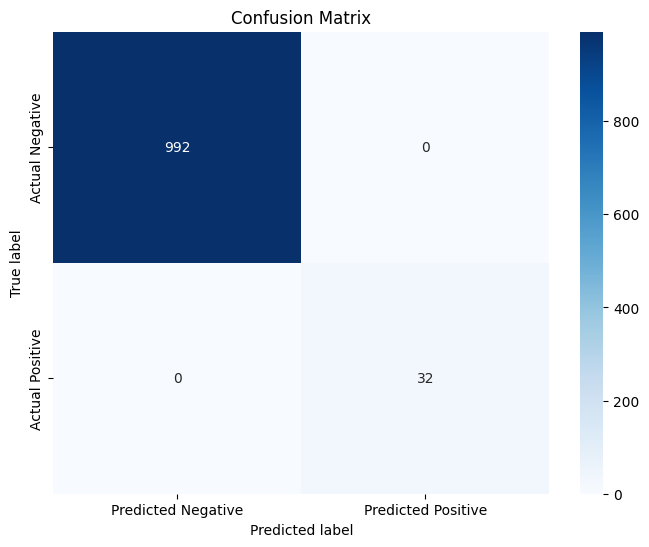

In [19]:
# Compute confusion matrix
cm = confusion_matrix(data[:,10:11], pred_test)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

<Axes: >

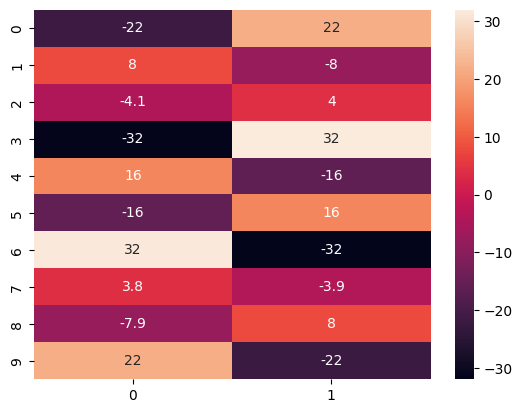

In [20]:
import seaborn as sns

sns.heatmap(param1['W1'], annot=True)